In [15]:
# April 2025
# Calculate similarity between positive titles and titles from repo
# Violeta Berdejo-Espinola & Ákos Hájas

In [1]:
# %pip install polars pyarrow

import polars as pl

In [2]:
# read data

df_repo = pl.read_csv('../data/outputs_pre-processing/repo_eng_metadata.csv', encoding='utf8')
df_pos = pl.read_csv('../data/outputs_pre-processing/pos_eng_metadta.csv', encoding='utf8')

print(len(df_repo), len(df_pos))

df_repo = df_repo.unique(subset="title")
df_pos = df_pos.unique(subset="title")

len(df_repo), len(df_pos)

378466 5474


(378466, 5474)

In [3]:
# create list of pos titles and repo titles and title and abstract

pos_title = df_pos.select(
    pl.col("title").cast(pl.Utf8)
    )["title"].to_list()

repo_title = df_repo.select(
    pl.col('title').cast(pl.Utf8)
    )['title'].to_list()

len(repo_title), len(pos_title)

(378466, 5474)

# compute similarity between titles

similarity threshold 0.9 - input: all titles

In [4]:
# check similarity 
# %time 21:53

from Levenshtein import ratio

# batch positive titles to reduce memory workload
BATCH_SIZE = 50

df_similarity = []

for i in range(0, len(pos_title), BATCH_SIZE):
    collect_similarity = {}

    # check similarity
    for title in pos_title[i:i+BATCH_SIZE]:
        collect_similarity[title] = [
            i for i, rt in enumerate(repo_title) 
            if ratio(title, rt) > 0.9
            ]
    
    print(f'batch {i} completed')
        
    # save to disk
    df = pl.DataFrame({
        'title': list(collect_similarity.keys()), 
        'similarity': list(collect_similarity.values())
        })
    
    df_similarity.append(df)
  
df_similarity = pl.concat(df_similarity, how="vertical")
len(df_similarity)

batch 0 completed
batch 50 completed
batch 100 completed
batch 150 completed
batch 200 completed
batch 250 completed
batch 300 completed
batch 350 completed
batch 400 completed
batch 450 completed
batch 500 completed
batch 550 completed
batch 600 completed
batch 650 completed
batch 700 completed
batch 750 completed
batch 800 completed
batch 850 completed
batch 900 completed
batch 950 completed
batch 1000 completed
batch 1050 completed
batch 1100 completed
batch 1150 completed
batch 1200 completed
batch 1250 completed
batch 1300 completed
batch 1350 completed
batch 1400 completed
batch 1450 completed
batch 1500 completed
batch 1550 completed
batch 1600 completed
batch 1650 completed
batch 1700 completed
batch 1750 completed
batch 1800 completed
batch 1850 completed
batch 1900 completed
batch 1950 completed
batch 2000 completed
batch 2050 completed
batch 2100 completed
batch 2150 completed
batch 2200 completed
batch 2250 completed
batch 2300 completed
batch 2350 completed
batch 2400 comp

5474

In [5]:
# flatten similarity lists --> labels

df_master = df_similarity.with_columns(
    label=pl.col("similarity")
    .list
    .len()
    )
print(len(df_master))
print(df_master['label'].value_counts())

df_master = df_master.explode('similarity')

len(df_master) # length increases as new rows are created for those titles with 1+ matches

# df_repo[316434]
# df_master.head()
# print(df_master['label'].value_counts())

5474
shape: (3, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ u32   ┆ u32   │
╞═══════╪═══════╡
│ 2     ┆ 19    │
│ 1     ┆ 4546  │
│ 0     ┆ 909   │
└───────┴───────┘


5493

# find similar instances across dfs


In [6]:
# find total matches: titles with one andfor titles with 1+
# %time 4:33

similarity_data_list = []

# loop through df_master 
for row_master in df_master.rows(named=True):
    similarity_master = row_master['similarity']
    title_master = row_master['title']

    # loop through repo titles with index
    for i, row_repo in enumerate(df_repo['title']):
        
        if i == similarity_master:
            print(f"Match found: {row_repo}")
            df_repo.with_columns(pos_similarity=similarity_master)
            
            similarity_data = {
                'position_in_repo':i,
                'similarity':similarity_master,
                'name_in_repo':row_repo,
                'name_in_pos':title_master,
                'label':1
            }
            
            similarity_data_list.append(similarity_data)

# create dataframe
matches_df = pl.DataFrame(similarity_data_list)

Match found: To what extent do forest herbs recover after clearcutting in beech forest?
Match found: The effect of sward height and drainage on common starlings sturnus vulgaris and northern lapwings vanellus vanellus foraging in grassland habitats
Match found: Disentangling effects of fire, habitat, and climate on an endangered prairie-specialist butterfly
Match found: The use of nest boxes by arboreal marsupials in the forests of the central highlands of victoria
Match found: Fall and rise of nesting green turtles (chelonia mydas) at aldabra atoll, seychelles: positive response to four decades of protection (1968-2008)
Match found: Describing vegetation succession after bracken control: evaluation of the rebra model
Match found: Restoration of species-rich grassland on arable land: assessing the limiting processes using a multi-site experiment
Match found: Effects of herbicide on the invasive biennial alliaria petiolata (garlic mustard) and initial responses of native plants in a sou

In [7]:
matches_df

position_in_repo,similarity,name_in_repo,name_in_pos,label
i64,i64,str,str,i64
244351,244351,"""To what extent do forest herbs…","""To what extent do forest herbs…",1
198887,198887,"""The effect of sward height and…","""The effect of sward height and…",1
286732,286732,"""Disentangling effects of fire,…","""Disentangling effects of fire,…",1
1334,1334,"""The use of nest boxes by arbor…","""The use of nest boxes by arbor…",1
162394,162394,"""Fall and rise of nesting green…","""Fall and rise of nesting green…",1
…,…,…,…,…
264286,264286,"""Determinants of postfire recov…","""Determinants of postfire recov…",1
78291,78291,"""Variation in winter wildfowl n…","""Variation in winter wildfowl n…",1
32449,32449,"""Use of riparian buffer strips …","""Use of riparian buffer strips …",1


In [8]:
# get unique names

# save duplicated titles in df 

matches_duplicates = matches_df.filter(
    pl.col("name_in_repo").is_in(
        matches_df.select("name_in_repo")
          .group_by("name_in_repo")
          .agg(pl.count().alias("count"))
          .filter(pl.col("count") > 1)
          .get_column("name_in_repo")
    )
)

print(matches_duplicates)

# remove duplicates

matches_df = matches_df.unique(subset="name_in_repo")
len(matches_df) # from 4582 to 4569 -> 13 duplicates ~ 26 instances
print(4582 - 4569)

shape: (26, 5)
┌──────────────────┬────────────┬─────────────────────────────┬────────────────────────────┬───────┐
│ position_in_repo ┆ similarity ┆ name_in_repo                ┆ name_in_pos                ┆ label │
│ ---              ┆ ---        ┆ ---                         ┆ ---                        ┆ ---   │
│ i64              ┆ i64        ┆ str                         ┆ str                        ┆ i64   │
╞══════════════════╪════════════╪═════════════════════════════╪════════════════════════════╪═══════╡
│ 209294           ┆ 209294     ┆ Creation of island habitats ┆ Creation of 'island'       ┆ 1     │
│                  ┆            ┆ in…                         ┆ habitats …                 ┆       │
│ 300260           ┆ 300260     ┆ Creation of island habitats ┆ Creation of 'island'       ┆ 1     │
│                  ┆            ┆ in…                         ┆ habitats …                 ┆       │
│ 38586            ┆ 38586      ┆ Short-term response of      ┆ Short-term r

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_76124/4112355693.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


In [10]:
print(f"articles in master: {len(df_master)}")

print(f"articles in pos matches {len(matches_df)}")


articles in master: 5493
articles in pos matches 4571


In [11]:
# check if titles are actually in repo using isin funtion

sim_is_in_repo = (matches_df.with_columns(
    pl.col('name_in_repo')
    .is_in(matches_df['name_in_pos'])
    .alias("exists_in_repo")
    )
)

sim_is_in_repo 

# readme
# articles ARE in repo. isin returns FALSE similarities as it is more strict with the similarity measure
# however, after inspection, these seemingly false actually are in repo. Title differences are spaces, or dahses, etc

position_in_repo,similarity,name_in_repo,name_in_pos,label,exists_in_repo
i64,i64,str,str,i64,bool
175956,175956,"""Population recovery following …","""Population recovery following …",1,true
256467,256467,"""Benefit of permanent non-fire …","""Benefit of permanent non-fire …",1,true
160738,160738,"""Effects of changes in the size…","""Effects of changes in the size…",1,true
55213,55213,"""Influence of soil properties o…","""Influence of soil properties o…",1,true
290328,290328,"""Sheep preference for leafy spu…","""Sheep preference for leafy spu…",1,true
…,…,…,…,…,…
51977,51977,"""Insert modifications improve a…","""Insert modifications improve a…",1,true
155033,155033,"""Revegetating disturbance in na…","""Revegetating disturbance in na…",1,true
331520,331520,"""First survey of fishes in the …","""First survey of fishes in the …",1,true


# unmatched rows

In [12]:
# create df

# filter rows in master that are not in pos matches
unmatched_pos =  df_master.filter(
    (~pl.col('title')
     .is_in(matches_df['name_in_pos']))
)

unmatched_pos = unmatched_pos.unique(subset="title")

print(len(unmatched_pos))
unmatched_pos

917


title,similarity,label
str,i64,u32
"""The conservation breeding of t…",null,0
"""Movements and dive patterns of…",null,0
"""The austed ii, an improved tra…",null,0
"""Dormant season prescribed fire…",null,0
"""Salvage of eggs from road-kill…",null,0
…,…,…
"""Vessel speed increases collisi…",null,0
"""Use of seagrass wrack in resto…",null,0
"""Habitat management for the kar…",null,0


# add labels

In [13]:
# add labels to positive instances in matches_df

matches_df = matches_df.with_columns(
    pl.lit(1).alias('label')
)

# subset pos matches tiltes

matches_df_short =  matches_df.select(
    pl.col(['name_in_repo','label'])
)

# merge pos_matched and repo

repo_and_matches = df_repo.join(matches_df_short, how='left', left_on='title', right_on='name_in_repo')

# add labels to negative instances in repo_full

repo_and_matches = repo_and_matches.with_columns(
    pl.when(pl.col("label") == 1)
    .then("label")
    .otherwise(0).alias("label")
)

In [14]:
print(len(matches_df))
print(len(df_repo))
print(len(repo_and_matches))
repo_and_matches['label'].value_counts()

4571
378466
378466


label,count
i32,u32
0,373895
1,4571


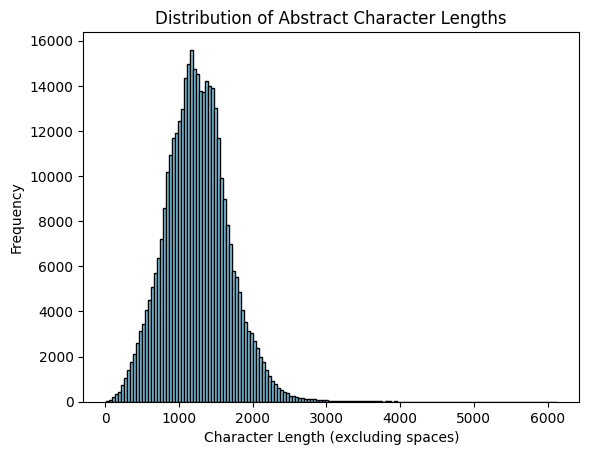

378466


In [15]:
import matplotlib.pyplot as plt

# Calculate character lengths excluding spaces
char_lens = [len(abstract.replace(" ", "")) for abstract in repo_and_matches['abstract']]

# Plot the histogram
plt.hist(char_lens, bins=150, color='skyblue', edgecolor='black')
plt.xlabel('Character Length (excluding spaces)')
plt.ylabel('Frequency')
plt.title('Distribution of Abstract Character Lengths')
plt.show()
print(len(repo_and_matches))

In [17]:
# remove instances with an abstract shorter than 300 characters

repo_and_matches = repo_and_matches.with_columns(
    pl.col("abstract")
    .str.len_chars()
    .alias("abstract_length")
)

repo_and_matches = repo_and_matches.filter(
    pl.col("abstract_length") >= 300
)

print(len(repo_and_matches))

376619


In [18]:
repo_and_matches['label'].value_counts()

label,count
i32,u32
1,4565
0,372054


In [20]:
repo_and_matches.describe()

statistic,level_0,index,title,abstract,journal,year,authors,language,label,abstract_length
str,f64,f64,str,str,str,f64,str,str,f64,f64
"""count""",376619.0,376619.0,"""376619""","""376619""","""376619""",376619.0,"""376619""","""376619""",376619.0,376619.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0
"""mean""",214268.614836,259287.018855,null,null,null,2006.053903,null,null,0.012121,1470.105884
"""std""",125005.16106,149521.745739,null,null,null,11.277313,null,null,0.109426,501.982301
"""min""",223.0,250.0,"""&iteretmochelys imbricata&it s…","""! An oligotrophic coastal fres…","""Acta chiropterologica""",1936.0,"""A'Bear, AD; Boddy, L; Jones, T…","""en""",0.0,300.0
"""25%""",108579.0,134145.0,null,null,null,2000.0,null,null,0.0,1128.0
"""50%""",211384.0,256400.0,null,null,null,2008.0,null,null,0.0,1448.0
"""75%""",323401.0,390564.0,null,null,null,2015.0,null,null,0.0,1771.0
"""max""",436752.0,524432.0,"""Δ15n variation in ulva lactuca…","""{en} Over the past decades, mu…","""Zoo biology""",2025.0,"""Üzüm, N; Olgun, K""","""en""",1.0,7214.0


In [21]:
# save to disk

df_master.write_parquet('../data/outputs_similarity_matches/pos_eng_similarity_ratio.parquet')
df_master.write_csv('../data/outputs_similarity_matches/pos_eng_similarity_ratio.csv')
matches_df.write_parquet('../data/outputs_similarity_matches/pos_eng_matches.parquet')
matches_df.write_csv('../data/outputs_similarity_matches/pos_eng_matches.csv')
unmatched_pos.write_parquet('../data/outputs_similarity_matches/pos_eng_unmatched.parquet')
unmatched_pos.write_csv('../data/outputs_similarity_matches/pos_eng_unmatched.csv')

repo_and_matches.write_parquet('../data/outputs_similarity_matches/corpus_eng.parquet')
repo_and_matches.write_csv('../data/outputs_similarity_matches/corpus_eng.csv')

In [22]:
len(df_repo), len(df_master), len(matches_df), len(unmatched_pos)

(378466, 5493, 4571, 917)

In [24]:
repo_and_matches["label"].value_counts()

label,count
i32,u32
1,4565
0,372054
